<a href="https://colab.research.google.com/github/mustafayoruk/diabetes-prediction-tensorflow/blob/main/diabetes_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veri 'Excel' formatında başarıyla yüklendi.

Model eğitiliyor, lütfen bekleyiniz...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


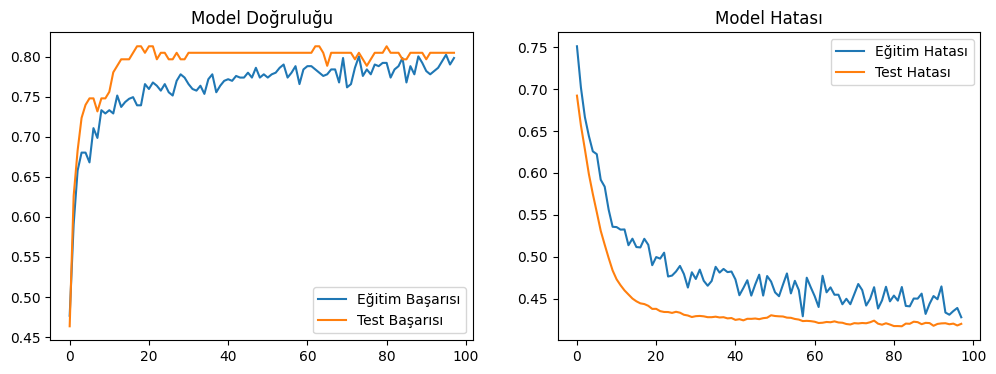


      DETAYLI PERFORMANS ANALİZİ

1. MODELİN KARNESİ (Doğru ve Yanlış Sayıları):
--------------------------------------------------
                  Tahmin: Sağlıklı  Tahmin: Diyabet
Gerçek: Sağlıklı                84               16
Gerçek: Diyabet                 25               29
--------------------------------------------------
Yorum:
- 29 kişiyi DOĞRU teşhis etmiş (Diyabet).
- 84 kişiye DOĞRU 'Sağlıklı' demiş.
- 25 hastayı GÖZDEN KAÇIRMIŞ (Riskli Hata!).
- 16 sağlıklı kişiye BOŞUNA 'Hastasın' demiş.


2. HASTA BAZLI ÖRNEK KARŞILAŞTIRMA (İlk 10 Kişi):
------------------------------------------------------------
Gerçek Durum Modelin Tahmini  Güven Oranı (%)
    Sağlıklı         Diyabet        72.139999
    Sağlıklı        Sağlıklı        21.330000
    Sağlıklı        Sağlıklı        28.549999
     Diyabet        Sağlıklı        38.299999
    Sağlıklı        Sağlıklı         0.060000
    Sağlıklı        Sağlıklı        29.770000
     Diyabet        Sağlıklı        40.480000
   

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# --- 1. VERİYİ YÜKLEME ---
try:
    # Önce Excel olarak dene
    df = pd.read_excel('/content/diabetes.xlsx')
    print("Veri 'Excel' formatında başarıyla yüklendi.")
except:
    try:
        # Olmazsa CSV olarak dene
        df = pd.read_csv('diabetes.csv')
        print("Veri 'CSV' formatında başarıyla yüklendi.")
    except:
        print("HATA: Dosya bulunamadı. Lütfen sol menüden dosya adını kontrol et.")

if 'df' in locals():
    # --- 2. VERİ HAZIRLIĞI ---
    X = df.drop('Outcome', axis=1).values
    y = df['Outcome'].values

    # %80 Eğitim, %20 Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 3. MODELİ KUR ---
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    # --- 4. EĞİTİM ---
    print("\nModel eğitiliyor, lütfen bekleyiniz...")
    history = model.fit(
        X_train_scaled, y_train,
        epochs=150,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # --- 5. SONUÇLAR VE TABLOLAR ---

    # Tahminleri yap
    y_pred_probs = model.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    # Grafik Çizimi
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
    plt.plot(history.history['val_accuracy'], label='Test Başarısı')
    plt.title('Model Doğruluğu')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Hatası')
    plt.plot(history.history['val_loss'], label='Test Hatası')
    plt.title('Model Hatası')
    plt.legend()

    plt.show()

    print("\n" + "="*50)
    print("      DETAYLI PERFORMANS ANALİZİ")
    print("="*50)

    # -- TABLO 1: KARNE (Confusion Matrix) --
    cm = confusion_matrix(y_test, y_pred)

    # Değerleri değişkenlere atayalım (Hata riskini sıfırlar)
    dogru_saglikli = cm[0, 0]
    yanlis_alarm = cm[0, 1]
    gozden_kacan = cm[1, 0]
    dogru_hasta = cm[1, 1]

    cm_df = pd.DataFrame(cm, index=["Gerçek: Sağlıklı", "Gerçek: Diyabet"],
                         columns=["Tahmin: Sağlıklı", "Tahmin: Diyabet"])

    print("\n1. MODELİN KARNESİ (Doğru ve Yanlış Sayıları):")
    print("-" * 50)
    print(cm_df)
    print("-" * 50)

    # Basit yazdırma (Syntax hatası riskine karşı f-string yerine virgül kullandım)
    print("Yorum:")
    print("-", dogru_hasta, "kişiyi DOĞRU teşhis etmiş (Diyabet).")
    print("-", dogru_saglikli, "kişiye DOĞRU 'Sağlıklı' demiş.")
    print("-", gozden_kacan, "hastayı GÖZDEN KAÇIRMIŞ (Riskli Hata!).")
    print("-", yanlis_alarm, "sağlıklı kişiye BOŞUNA 'Hastasın' demiş.")

    # -- TABLO 2: ÖRNEK KARŞILAŞTIRMA --
    results_df = pd.DataFrame({
        'Gerçek Durum': y_test.flatten(),
        'Modelin Tahmini': y_pred.flatten(),
        'Güven Oranı (%)': (y_pred_probs.flatten() * 100).round(2)
    })

    results_df['Gerçek Durum'] = results_df['Gerçek Durum'].map({0: 'Sağlıklı', 1: 'Diyabet'})
    results_df['Modelin Tahmini'] = results_df['Modelin Tahmini'].map({0: 'Sağlıklı', 1: 'Diyabet'})

    print("\n\n2. HASTA BAZLI ÖRNEK KARŞILAŞTIRMA (İlk 10 Kişi):")
    print("-" * 60)
    print(results_df.head(10).to_string(index=False))
    print("-" * 60)

    # Final Skor
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"\n---> GENEL DOĞRULUK ORANI: %{accuracy*100:.2f} <---")